In [1]:
import matplotlib.pyplot as plt
import argparse
import os
import sys
from os.path import join as pjoin
import numpy as np
import time
import datetime
import platform
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import datasets
from sklearn.metrics import average_precision_score as avg_precision
from collections import OrderedDict
import pickle
from matplotlib import cm
#import graphdata
#from image_superpixels import ImageSP
#import models as my_models
#import utils
#import pascal_loader
import networkx as nx
import cv2
from scipy.spatial.distance import cdist
#from sklearn.manifold import TSNE
import importlib
#import visdom
import matplotlib as mlp
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns
import chebygin as my_models
import attention_pooling
import importlib
import utils
from utils import *
from sklearn.metrics import roc_auc_score, roc_curve
import graphdata

In [2]:
def read_results(results_dir, epoch=50):
    acc = []
    for f in os.listdir(results_dir):
        with open(pjoin(results_dir, f), 'r') as fp:
            lines = fp.readlines()#[-1]        
        
        try:
            if lines[-1].find('cross validation avg acc') >= 0:
                s = lines[-1]
                pos1 = s.find(':')
                acc.append(float(s[pos1+1:s[pos1:].find('(') + pos1]))
            else:
                s = list(filter(lambda l: l.find('Test set (epoch %d):' % epoch) >= 0, lines))[0]
                pos1 = s.find(':')
                pos2 = pos1 + s[pos1:].find('%')
                pos1 = pos1 + s[pos1:].find('(')
                acc.append(float(s[pos1+1:pos2]))
        except:
            continue
    print(len(acc), np.mean(acc), np.std(acc), np.min(acc), np.max(acc))

In [3]:
read_results('/export/mlrg/bknyazev/projects/graph_nn/repeats/mcheb_paper/')

10 76.04583333333333 0.499241559121176 75.27380952380953 77.10714285714286


# COLLAB

In [75]:
[1e-4, 1e-3, 2e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1]

[0.0001, 0.001, 0.002, 0.005, 0.01, 0.03, 0.05, 0.1]

In [72]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/collab_global_max/')

10 65.895 3.0055423803366996 57.36 69.07


In [165]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/collab_unsup_10fold_fc32/')

7 64.37285714285714 3.218037175873847 56.71 66.8


In [74]:
#read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/collab_wsup_5fold_88nodes/')

In [47]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/collab_wsup_5fold/')

7 60.79428571428572 4.018250710882811 54.73 65.87


In [50]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/collab_wsup_10fold_fc32/')

4 61.620000000000005 3.689911923068082 56.24 66.11


# PROTEINS

In [40]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/proteins_global_max/')

10 72.691 1.5268100733228065 68.68 74.06


In [92]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/proteins_unsup_10fold/')

10 76.36200000000001 0.4289009209596077 75.53 77.0


In [91]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/proteins_wsup_5fold/')

10 76.136 0.9321072899618367 74.39 77.98


In [159]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/proteins_wsup_10fold/')

10 76.117 0.9059034164854448 74.55 77.81


# DD - 200

In [63]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/dd_200nodes_global_max/')

10 31.453000000000003 3.977773372126672 25.28 37.29


In [64]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/dd_unsup_200nodes_5fold/')

10 57.333000000000006 18.045085231164744 21.37 67.74


In [65]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/dd_unsup_200nodes_10fold/')

10 46.271 20.370703694276248 21.37 65.22


In [43]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/dd_wsup_200nodes_5fold/')

4 41.165 17.067058182358203 21.37 63.13


In [44]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/dd_unsup_200nodes_10fold_fc32/')

11 55.32000000000001 13.987241589131408 31.01 70.81


In [48]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/dd_wsup_200nodes_10fold_fc32/')

5 53.464 16.453896316678307 21.37 65.64


# DD - 300

In [86]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/dd_300nodes_global_max/')

10 73.6 2.0625178787103917 68.88 77.29


In [87]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/dd_unsup_300nodes_5fold/')

10 77.361 1.249731571178387 75.22 79.06


In [88]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/dd_unsup_300nodes_10fold/')

10 76.87299999999998 1.6824924962685572 72.86 78.76


In [162]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/dd_unsup_300nodes_10fold_fc32/')

10 78.09700000000001 1.4980791033854004 75.07 80.97


In [49]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/dd_wsup_300nodes_10fold_fc32/')

2 78.095 0.5150000000000006 77.58 78.61


# Visualizations

In [3]:
device = 'cpu'
def load_model(model_path, in_features=1, out_features=2, my_models=my_models):
    importlib.reload(utils)
    importlib.reload(attention_pooling)
    importlib.reload(my_models)
    state = torch.load(model_path, map_location=lambda storage, loc: storage)
    print(state['args'].filter_scale)
    
    model = my_models.ChebyGIN(in_features=in_features,
                              out_features=out_features,
                              K=state['args'].filter_scale,
                              filters=state['args'].filters,
                              dropout=state['args'].dropout,
                              n_hidden=state['args'].n_hidden,
                              aggregation=state['args'].aggregation,
                              pool=state['args'].pool,
                              pool_arch=state['args'].pool_arch)
    #     print(state['state_dict'])
    print(model)
    model.train()
    print('model capacity: %d' %
          np.sum([np.prod(p.size()) if p.requires_grad else 0 for p in model.parameters()]))

    model.eval()
    keys = list(state['state_dict'].keys())
    for key in keys:
        if key.find('layers') == 0:
            key_new = key.replace('layers', 'graph_layers')
            state['state_dict'][key_new] = state['state_dict'][key].clone()
            del state['state_dict'][key]
    try:
        model.load_state_dict(state['state_dict'])
    except Exception as e:
        print('ERROR!!!')
        print(e)
        raise
    model.eval()
    model.to(device)
    print(model)
    return model


In [4]:
def get_graph(data_test, index, draw=True):
    A = data_test.adj_list[index]
    #print(data_test.features_onehot[index].shape, A.shape)
    G = nx.from_numpy_array(A)
    pos = nx.spring_layout(G)
    if draw:
        nx.draw(G, pos, node_size=200, node_color=np.ones(3), edgecolors=np.zeros(3))
        plt.show()
        print('label', data_test.labels[index])
    return A, G, pos

In [5]:
# graph_pos, graph_neg = [], []
edgecolors = [0.5, 0.5, 0.5, 0.1] #np.zeros(3)
cmap = 'Purples'
edgewidth = 0.3

def plot_pooled(index, alpha, thresh):
    fig = plt.figure()
    A = data_test.adj_list[index].copy()
    idx = np.where(alpha[index] > thresh)[0]    
    n = len(idx)
    A = A[:,idx][idx, :]
    G = nx.from_numpy_array(A)
    pos_new = {}
    for j in range(len(idx)):
        pos_new[j] = pos[idx[j]] #+ np.array([0, -0.1])        
    
    idx_d = np.where(alpha[index] <= thresh)[0]
    if len(idx_d) > 0:            
        G_dummy = nx.from_numpy_array(data_test.adj_list[index][:,idx_d][idx_d, :])
        pos_dummy = {}
        for j in range(len(idx_d)):
            pos_dummy[j] = pos[idx_d[j]]        
        nx.draw(G_dummy, pos_dummy, node_color=np.ones((len(pos_dummy), 3)), edge_color='w',
                               node_size=100, width=0, alpha=0)
        
    vmin = alpha[index].min()
    vmax = alpha[index].max()
    colors = alpha[index].copy()[idx]
    nx.draw(G, pos_new, node_color=colors, node_size=100, with_labels=False, width=edgewidth,
                     edgecolors=edgecolors, cmap=cmap, vmin=vmin, vmax=vmax)
    
    return n

# PROTEINS

In [102]:
datareader = graphdata.DataReader(data_dir='/mnt/data/bknyazev/data/graph_data/PROTEINS',
                                  rnd_state=np.random.RandomState(6149),
                                  N_nodes=25,
                                  use_cont_node_attr=False,
                                  folds=10)
data_train = graphdata.GraphData(datareader, 0, split='train_val')
data_test = graphdata.GraphData(datareader, 0, split='test')

N nodes avg/std/min/max: 	39.06/45.76/4/620
N edges avg/std/min/max: 	72.82/84.60/5/1049
Node degree avg/std/min/max: 	3.73/1.15/0/25
Node features dim: 		3
N classes: 			2
Classes: 			[0 1]
Class 0: 			663 samples
Class 1: 			450 samples
feature 0, count 21151/43471
feature 1, count 20931/43471
feature 2, count 1389/43471
548/1113 graphs with at least 25 nodes
generating 10-fold cross-validation splits
0 450 50
1 450 50
2 450 50
3 450 50
4 450 50
5 450 50
6 450 50
7 450 50
8 450 50
9 450 50
TRAIN_VAL: 500/1113
Class 0: 			209 samples
Class 1: 			291 samples
TEST: 613/1113
Class 0: 			454 samples
Class 1: 			159 samples


In [103]:
with open('/mnt/data/bknyazev/checkpoints/TU_alpha_WS_test_seed6149_orig.pkl', 'rb') as f:
    attn_WS = pickle.load(f)
len(attn_WS)    

613

In [219]:
# /export/mlrg/bknyazev/projects/XAI/Model/graph_examples/results/proteins/attention_25/wsup_10/K3_f64_64_64_lr0.001_proj4/sup_p0.1_K3_f64_50epochs_shape_split_25nodes_lr0.001_seed468.log
#model = load_model('/mnt/data/bknyazev//checkpoints/checkpoint_PROTEINS_GPU10_764088_fold0_epoch50.pth.tar', 620, 3)

# /export/mlrg/bknyazev/projects/graph_attention_pool/results/proteins_wsup_10fold/proteins_wsup_10fold_cv_seed6149.log
model_wsup = load_model('/mnt/data/bknyazev/checkpoints//checkpoint_TU_ws13.cfs.uoguelph.ca_445197_epoch50_seed0006149.pth.tar', 3)
thresh = 0.002

model_global = load_model('/mnt/data/bknyazev/checkpoints//checkpoint_TU_GPU9_747767_epoch50_seed0006149.pth.tar', 3)
model_unsup = load_model('/mnt/data/bknyazev/checkpoints//checkpoint_TU_GPU9_472105_epoch50_seed0006149.pth.tar', 3)
thresh_unsup = 0.005

3
ChebyGINLayer torch.Size([64, 9]) tensor([0.4282, 0.6232, 0.5401, 0.5318, 0.6118, 0.5857, 0.5565, 0.5706, 0.5598,
        0.5187], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 192]) tensor([0.5579, 0.5738, 0.5711, 0.5982, 0.5795, 0.5689, 0.5678, 0.5458, 0.6014,
        0.5763], grad_fn=<SliceBackward>)
p values [ 0.74426347 -0.82976276 -1.1412928   0.4954253   1.1750543   2.3294609
  0.64172244  0.5664481   0.31215465  0.28255412 -0.33129054 -0.42722288
  0.8253211   1.0853859  -0.9391079  -0.26239255 -0.24683398 -0.4456689
  2.0224779  -0.7129429   1.5803217  -2.5425966  -0.27909908 -0.10771029
 -1.7644132  -0.3240248  -1.6030697   1.3436424   1.3915833   0.50900644
  0.20076683 -1.0060657   0.9160538   0.46941373  0.24284095 -0.6083373
 -0.26640674  0.00648625  1.3121926   0.44876415  0.15155101  1.1403699
 -0.3414145  -1.2441059   1.1463296   0.44225335  0.2783756   1.938887
  0.34961557 -0.82403505  0.662221    0.81843036 -1.498716    0.5897742
  0.22653154  1.9702047  

In [122]:
pred_wsup, pred_unsup, pred_global, alpha_wsup, alpha_unsup = [], [], [], [], []
for index in range(len(data_test.adj_list)):
    A = data_test.adj_list[index]
    n = A.shape[0]
    data = [torch.from_numpy(data_test.features_onehot[index]).unsqueeze(0).float().to(device).expand(2, -1, -1),
                torch.from_numpy(A).unsqueeze(0).float().to(device).to(device).expand(2, -1, -1),
                torch.ones(2, n, dtype=torch.uint8).to(device),
                torch.zeros(2).to(device),
                {'N_nodes': torch.zeros(2, 1).long().to(device) + n,
                 'node_attn': torch.zeros(2, n).float().to(device)}]
    y, output = model_wsup(copy_batch(data))
    #print(y, output[1][0].shape)
    alpha_wsup.append(output['alpha'][0][0].data.numpy())
    pred_wsup.append(torch.argmax(y[0]).item())
    
    y, output = model_unsup(copy_batch(data))
    alpha_unsup.append(output['alpha'][0][0].data.numpy())
    pred_unsup.append(torch.argmax(y[0]).item())
    
    y, output = model_global(copy_batch(data))
    pred_global.append(torch.argmax(y[0]).item())
    
print(len(pred_wsup), len(alpha_wsup), len(pred_unsup), len(alpha_unsup))
print(np.mean(np.equal(np.array(pred_wsup), data_test.labels)))
print(np.mean(np.equal(np.array(pred_unsup), data_test.labels)))
print(np.mean(np.equal(np.array(pred_global), data_test.labels)))

613 613 613 613
0.7699836867862969
0.763458401305057
0.7226753670473083


437 pos 0 0


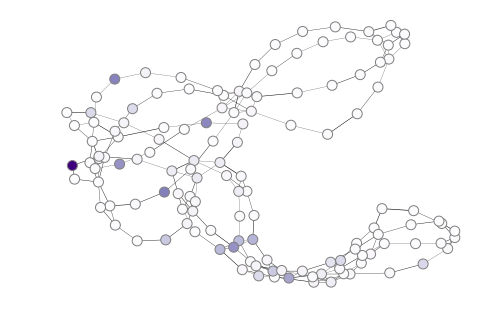

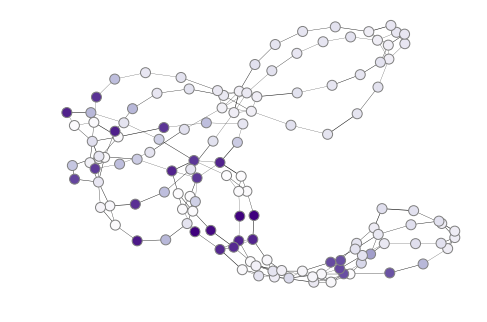

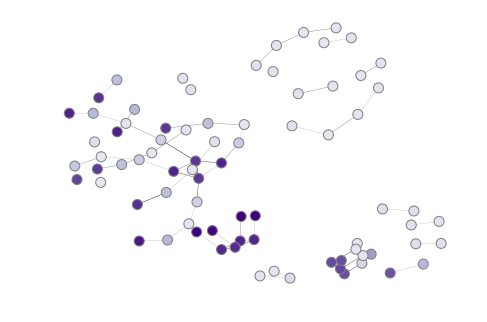

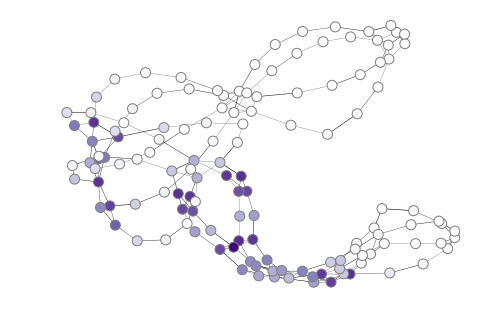

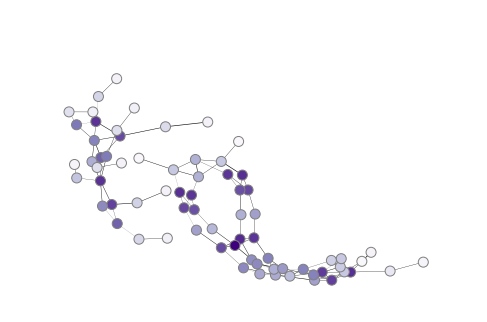

In [157]:
for index in [437]:#range(len(data_test.adj_list)):
    A, G, pos = get_graph(data_test, index, draw=False)
    n = A.shape[0]    
    idx_d = np.where(alpha_wsup[index] <= thresh)[0]
    label = data_test.labels[index]    
    r = len(idx_d) / float(n) * 100
    pred = pred_wsup[index]
    if label == pred:
        sfx = 'pos'
#         graph_pos.append((A, alpha_wsup[index], label))
    else:
        sfx = 'neg'
#         graph_neg.append((A, alpha_wsup[index], label))
    
    print(index, sfx, label, pred)
    
    fig = plt.figure()
    nx.draw(G, pos, node_size=100, node_color=attn_WS[index], #graph_pos[0][1], 
            edgecolors=edgecolors, width=A.sum(1) / 10., cmap=cmap)    
    plt.savefig('images/proteins/wsup/label%d/%s/%d_%d_%dnodes_%d_%d_global.pdf' % 
                (label, sfx, r, index, n, label, pred_global[index]))
    plt.show()
    

    
    fig = plt.figure()
    nx.draw(G, pos, node_size=100, node_color=alpha_unsup[index], #graph_pos[0][1], 
            edgecolors=edgecolors, width=A.sum(1) / 10., cmap=cmap)    
    plt.savefig('images/proteins/wsup/label%d/%s/%d_%d_%dnodes_%d_%d_unsup.pdf' % 
                (label, sfx, r, index, n, label, pred_unsup[index]))
    plt.show()
    
    n = plot_pooled(index, alpha_unsup, thresh_unsup)
    plt.axis('off')
    plt.savefig('images/proteins/wsup/label%d/%s/%d_%d_%dnodes_%d_%d_unsup_pooled.pdf' % (label, sfx, r, 
                                                                                    index, n, label, pred_unsup[index]))
    
        
    fig = plt.figure()
    nx.draw(G, pos, node_size=100, node_color=alpha_wsup[index], #graph_pos[0][1], 
            edgecolors=edgecolors, width=A.sum(1) / 10., cmap=cmap)    
    plt.savefig('images/proteins/wsup/label%d/%s/%d_%d_%dnodes_%d_%d.pdf' % (label, sfx, r, 
                                                                             index, A.shape[0], label, pred))
    plt.show()
    
    n = plot_pooled(index, alpha_wsup, thresh)
    plt.axis('off')
    plt.savefig('images/proteins/wsup/label%d/%s/%d_%d_%dnodes_%d_%d_pooled.pdf' % (label, sfx, r, 
                                                                                    index, n, label, pred_wsup[index]))
#     plt.savefig('images/proteins/wsup/label%d/%s/%d_pooled_%dnodes.png' % (label, sfx, index, n), 
#                 dpi=300, transparent=True)
    plt.show()
# len(graph_pos), len(graph_neg)

# COLLAB

In [6]:
seed = 9055
with open('/mnt/data/bknyazev/checkpoints/TU_alpha_WS_test_seed%d_orig.pkl' % seed, 'rb') as f:
    attn_WS = pickle.load(f)
len(attn_WS)    

4500

In [7]:
# /export/mlrg/bknyazev/projects/XAI/Model/graph_examples/results/collab/attention_35/wsup_0.5/K3_f64_64_64_lr0.001_proj6/sup_p0.002_K3_f64_50epochs_shape_split_35nodes_lr0.001_seed127.log
# model = load_model('/mnt/data/bknyazev//checkpoints/checkpoint_COLLAB_GPU8_117099_fold0_epoch50.pth.tar', 492, 493, 3)

model_wsup = load_model('/mnt/data/bknyazev//checkpoints/checkpoint_TU_GPU9_741543_epoch50_seed0009055.pth.tar', 492, 3)
model_unsup = load_model('/mnt/data/bknyazev//checkpoints/checkpoint_TU_ws13.cfs.uoguelph.ca_374672_epoch50_seed0009055.pth.tar', 492, 3)
model_global = load_model('/mnt/data/bknyazev//checkpoints/checkpoint_TU_ws13.cfs.uoguelph.ca_501971_epoch50_seed0009055.pth.tar', 492, 3)
thresh = 0.002
thresh_unsup = 0.001

3
ChebyGINLayer torch.Size([64, 1476]) tensor([0.5715, 0.5752, 0.5724, 0.5724, 0.5798, 0.5757, 0.5762, 0.5570, 0.5769,
        0.5788], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 192]) tensor([0.5750, 0.5917, 0.5611, 0.5809, 0.5465, 0.5993, 0.5827, 0.5742, 0.5519,
        0.5563], grad_fn=<SliceBackward>)
cos_sim 0.2402859926223755
cos_sim -0.21517303586006165
cos_sim -0.009152427315711975
cos_sim 0.1543944627046585
ChebyGINLayer torch.Size([64, 192]) tensor([0.5678, 0.5910, 0.5860, 0.5838, 0.5623, 0.5633, 0.5935, 0.5795, 0.5796,
        0.5870], grad_fn=<SliceBackward>)
ChebyGIN(
  (graph_layers): Sequential(
    (0): ChebyGINLayer(in_features=492, out_features=64, K=3, n_hidden=0, aggregation=mean)
    fc=Sequential(
      (0): Linear(in_features=1476, out_features=64, bias=True)
      (1): ReLU(inplace)
    )
    (1): ChebyGINLayer(in_features=64, out_features=64, K=3, n_hidden=0, aggregation=mean)
    fc=Sequential(
      (0): Linear(in_features=192, out_features=64, bi

In [8]:
datareader = graphdata.DataReader(data_dir='/mnt/data/bknyazev/data/graph_data/COLLAB/',
                                  rnd_state=np.random.RandomState(seed),
                                  N_nodes=35,
                                  use_cont_node_attr=False,
                                  folds=10)
data_train = graphdata.GraphData(datareader, 0, split='train_val')
data_test = graphdata.GraphData(datareader, 0, split='test')

N nodes avg/std/min/max: 	74.49/62.30/32/492
N edges avg/std/min/max: 	2457.35/6438.91/60/40119
Node degree avg/std/min/max: 	65.98/79.23/1/491
Node features dim: 		492
N classes: 			3
Classes: 			[0 1 2]
Class 0: 			2600 samples
Class 1: 			775 samples
Class 2: 			1625 samples
681/5000 graphs with at least 35 nodes
generating 10-fold cross-validation splits
0 450 50
1 450 50
2 450 50
3 450 50
4 450 50
5 450 50
6 450 50
7 450 50
8 450 50
9 450 50
TRAIN_VAL: 500/5000
Class 0: 			229 samples
Class 1: 			137 samples
Class 2: 			134 samples
TEST: 4500/5000
Class 0: 			2371 samples
Class 1: 			638 samples
Class 2: 			1491 samples


In [9]:
pred_wsup, pred_unsup, pred_global, alpha_wsup, alpha_unsup = [], [], [], [], []
for index in range(len(data_test.adj_list)):
    A = data_test.adj_list[index]
    n = N_nodes = A.shape[0]
    D = np.sum(A, 1, keepdims=True)  # N,1  as in  [M. Simonovsky et al., CVPR'2017]
    D_onehot = np.zeros((N_nodes, 491 + 1))
    D_onehot[np.arange(N_nodes), D.astype(np.int).squeeze()] = 1

    data = [torch.from_numpy(D_onehot).unsqueeze(0).float().to(device).expand(2, -1, -1),
                torch.from_numpy(A).unsqueeze(0).float().to(device).to(device).expand(2, -1, -1),
                torch.ones(2, n, dtype=torch.uint8).to(device),
                torch.zeros(2).to(device),
                {'N_nodes': torch.zeros(2, 1).long().to(device) + n,
                 'node_attn': torch.zeros(2, n).float().to(device)}]
    y, output = model_wsup(copy_batch(data))
    #print(y, output[1][0].shape)
    alpha_wsup.append(output['alpha'][0][0].data.numpy())
    pred_wsup.append(torch.argmax(y[0]).item())
    
    y, output = model_unsup(copy_batch(data))
    alpha_unsup.append(output['alpha'][0][0].data.numpy())
    pred_unsup.append(torch.argmax(y[0]).item())
    
    y, output = model_global(copy_batch(data))
    pred_global.append(torch.argmax(y[0]).item())
    
print(len(pred_wsup), len(alpha_wsup), len(pred_unsup), len(alpha_unsup))
print(np.mean(np.equal(np.array(pred_wsup), data_test.labels)))
print(np.mean(np.equal(np.array(pred_unsup), data_test.labels)))
print(np.mean(np.equal(np.array(pred_global), data_test.labels)))

4500 4500 4500 4500
0.6635555555555556
0.6733333333333333
0.678


In [53]:
thresh = 0.0241
thresh_unsup = 0.002

96 pos 0 0 32 56.25


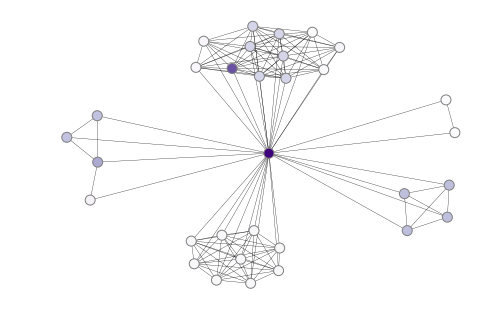

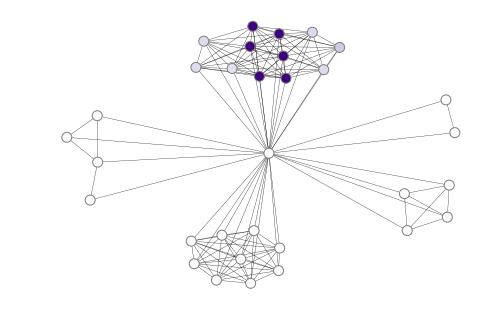

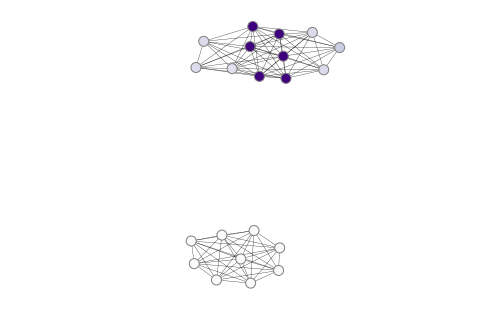

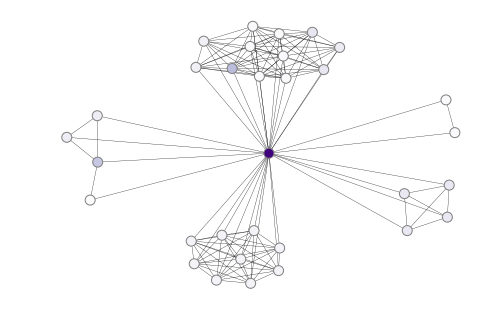

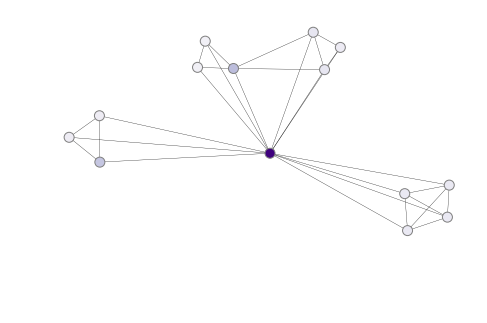

In [55]:
save = True
for index in [96]:#range(len(data_test.adj_list)):  # #[931]: 457, 1273, 893, 1001, 1739, 1932, 4455
    nx.shell_layout
    A = data_test.adj_list[index]
    n = A.shape[0]    
    idx_d = np.where(alpha_wsup[index] <= thresh)[0]
    label = data_test.labels[index]    
    r = len(idx_d) / float(n) * 100
    if r < 2 or n > 45:
        continue
    pred = pred_wsup[index]
    if label == pred:
        sfx = 'pos'
#         graph_pos.append((A, alpha_wsup[index], label))
    else:
        sfx = 'neg'
#         graph_neg.append((A, alpha_wsup[index], label))
    if label != pred:# or pred != 1:
        continue
    A, G, pos = get_graph(data_test, index, draw=False)
    print(index, sfx, label, pred, n, r)
    
    fig = plt.figure()
    nx.draw(G, pos, node_size=100, node_color=attn_WS[index], #graph_pos[0][1], 
            edgecolors=edgecolors, width=edgewidth, cmap=cmap)    # A.sum(1) / 10.
    if save:
        plt.savefig('images/collab/wsup/label%d/%s/%d_%d_%dnodes_%d_%d_global.pdf' % 
                    (label, sfx, r, index, n, label, pred_global[index]))
    plt.show()
    
    
    fig = plt.figure()
    nx.draw(G, pos, node_size=100, node_color=alpha_unsup[index], #graph_pos[0][1], 
            edgecolors=edgecolors, width=edgewidth, cmap=cmap)    
    if save:
        plt.savefig('images/collab/wsup/label%d/%s/%d_%d_%dnodes_%d_%d_unsup.pdf' % 
                    (label, sfx, r, index, n, label, pred_unsup[index]))
    plt.show()
    
    n = plot_pooled(index, alpha_unsup, thresh_unsup)
    plt.axis('off')
    if save:
        plt.savefig('images/collab/wsup/label%d/%s/%d_%d_%dnodes_%d_%d_unsup_pooled.pdf' % (label, sfx, r, 
                                                                                    index, n, label, pred_unsup[index]))
    
        
    fig = plt.figure()
    nx.draw(G, pos, node_size=100, node_color=alpha_wsup[index], #graph_pos[0][1], 
            edgecolors=edgecolors, width=edgewidth, cmap=cmap)    
    if save:
        plt.savefig('images/collab/wsup/label%d/%s/%d_%d_%dnodes_%d_%d.pdf' % (label, sfx, r, 
                                                                             index, A.shape[0], label, pred))
    plt.show()
    
    n = plot_pooled(index, alpha_wsup, thresh)
    plt.axis('off')
    if save:
        plt.savefig('images/collab/wsup/label%d/%s/%d_%d_%dnodes_%d_%d_pooled.pdf' % (label, sfx, r, 
                                                                                    index, n, label, pred_wsup[index]))
#     plt.savefig('images/proteins/wsup/label%d/%s/%d_pooled_%dnodes.png' % (label, sfx, index, n), 
#                 dpi=300, transparent=True)
    plt.show()
    #break

In [142]:
n = N_nodes = A.shape[0]
D = np.sum(A, 1, keepdims=True)  # N,1  as in  [M. Simonovsky et al., CVPR'2017]
D_onehot = np.zeros((N_nodes, 491 + 1))
D_onehot[np.arange(N_nodes), D.astype(np.int).squeeze()] = 1
print(D_onehot.shape, data_test.features_onehot[index].shape)
data = (torch.from_numpy(np.concatenate((data_test.features_onehot[index], D_onehot), axis=1)).unsqueeze(0).float().to(device).expand(2, -1, -1),
            None,
            torch.from_numpy(A).unsqueeze(0).unsqueeze(3).float().to(device).to(device).expand(2, -1, -1, -1),
            {'graph_support': torch.ones(2, n).float().to(device).to(device),
             'N_nodes': torch.zeros(2, 1).long().to(device) + n,
             'signal_attn': torch.zeros(2, n).float().to(device)})
y, output = model(data)[:2]
print(y, output[1][0].shape)
alpha = output[1][0][0, :].data.numpy()

(35, 492) (35, 1)
tensor([[ 1.2335,  2.3339, -3.6476],
        [ 1.2335,  2.3339, -3.6476]], grad_fn=<ThAddmmBackward>) torch.Size([2, 35])


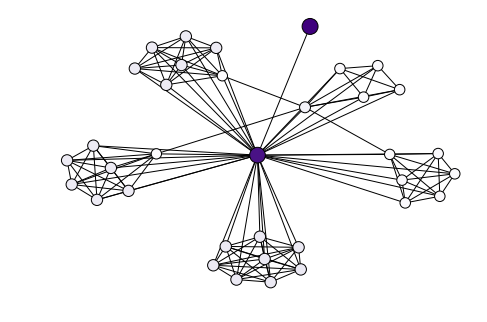

In [143]:
nx.draw(G, pos, node_color=alpha, node_size= (alpha + 0.1) * 1000, edgecolors=np.zeros(3), cmap='Purples')
plt.show()

# D&D

In [56]:
seed = 2375
with open('/mnt/data/bknyazev/checkpoints/TU_alpha_WS_test_seed%d_orig.pkl' % seed, 'rb') as f:
    attn_WS = pickle.load(f)
len(attn_WS)    

716

In [57]:
# /export/mlrg/bknyazev/projects/XAI/Model/graph_examples/results/collab/attention_35/wsup_0.5/K3_f64_64_64_lr0.001_proj6/sup_p0.002_K3_f64_50epochs_shape_split_35nodes_lr0.001_seed127.log
# model = load_model('/mnt/data/bknyazev//checkpoints/checkpoint_DD_GPU9_622565_fold0_epoch50.pth.tar', 5748, 89, 2)

# /export/mlrg/bknyazev/projects/XAI/Model/graph_examples/results/collab/attention_35/wsup_0.5/K3_f64_64_64_lr0.001_proj6/sup_p0.002_K3_f64_50epochs_shape_split_35nodes_lr0.001_seed127.log
# model = load_model('/mnt/data/bknyazev//checkpoints/checkpoint_COLLAB_GPU8_117099_fold0_epoch50.pth.tar', 492, 493, 3)

model_wsup = load_model('/mnt/data/bknyazev//checkpoints/checkpoint_TU_ws13.cfs.uoguelph.ca_753730_epoch50_seed0002375.pth.tar', 89)
model_unsup = load_model('/mnt/data/bknyazev//checkpoints/checkpoint_TU_ws13.cfs.uoguelph.ca_121561_epoch50_seed0002375.pth.tar', 89)
model_global = load_model('/mnt/data/bknyazev//checkpoints/checkpoint_TU_ws13.cfs.uoguelph.ca_722730_epoch50_seed0002375.pth.tar', 89)
thresh = 0.005
thresh_unsup = 0.005

3
ChebyGINLayer torch.Size([64, 267]) tensor([0.5637, 0.6030, 0.5978, 0.5594, 0.5798, 0.5395, 0.5811, 0.5726, 0.5780,
        0.5505], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 192]) tensor([0.5884, 0.5717, 0.5785, 0.5685, 0.5576, 0.5589, 0.5959, 0.5903, 0.6322,
        0.5727], grad_fn=<SliceBackward>)
cos_sim 0.1970425397157669
cos_sim -0.22245584428310394
cos_sim 0.012405656278133392
cos_sim 0.12298160791397095
ChebyGINLayer torch.Size([64, 192]) tensor([0.5671, 0.5579, 0.5914, 0.5794, 0.5973, 0.5728, 0.5887, 0.5507, 0.5835,
        0.5400], grad_fn=<SliceBackward>)
ChebyGIN(
  (graph_layers): Sequential(
    (0): ChebyGINLayer(in_features=89, out_features=64, K=3, n_hidden=0, aggregation=mean)
    fc=Sequential(
      (0): Linear(in_features=267, out_features=64, bias=True)
      (1): ReLU(inplace)
    )
    (1): ChebyGINLayer(in_features=64, out_features=64, K=3, n_hidden=0, aggregation=mean)
    fc=Sequential(
      (0): Linear(in_features=192, out_features=64, bias=

In [58]:
datareader = graphdata.DataReader(data_dir='/mnt/data/bknyazev/data/graph_data/DD/',
                                  rnd_state=np.random.RandomState(seed),
                                  N_nodes=200,
                                  use_cont_node_attr=False,
                                  folds=10)
data_train = graphdata.GraphData(datareader, 0, split='train_val')
data_test = graphdata.GraphData(datareader, 0, split='test')

N nodes avg/std/min/max: 	284.32/272.00/30/5748
N edges avg/std/min/max: 	715.66/693.91/63/14267
Node degree avg/std/min/max: 	5.03/1.69/1/19
Node features dim: 		89
N classes: 			2
Classes: 			[0 1]
Class 0: 			691 samples
Class 1: 			487 samples
feature 1, count 28071/334925
feature 2, count 16190/334925
feature 3, count 14656/334925
feature 4, count 19873/334925
feature 5, count 4750/334925
feature 6, count 12329/334925
feature 7, count 21831/334925
feature 8, count 25843/334925
feature 9, count 7608/334925
feature 10, count 18977/334925
feature 11, count 29527/334925
feature 12, count 19903/334925
feature 13, count 7275/334925
feature 14, count 13381/334925
feature 15, count 15627/334925
feature 16, count 19561/334925
feature 17, count 18897/334925
feature 18, count 4619/334925
feature 19, count 11886/334925
feature 20, count 23735/334925
feature 21, count 1/334925
feature 22, count 1/334925
feature 23, count 2/334925
feature 24, count 1/334925
feature 25, count 1/334925
feature 26

In [59]:
pred_wsup, pred_unsup, pred_global, alpha_wsup, alpha_unsup = [], [], [], [], []
for index in range(len(data_test.adj_list)):
    A = data_test.adj_list[index]
    n = A.shape[0]
    data = [torch.from_numpy(data_test.features_onehot[index]).unsqueeze(0).float().to(device).expand(2, -1, -1),
                torch.from_numpy(A).unsqueeze(0).float().to(device).to(device).expand(2, -1, -1),
                torch.ones(2, n, dtype=torch.uint8).to(device),
                torch.zeros(2).to(device),
                {'N_nodes': torch.zeros(2, 1).long().to(device) + n,
                 'node_attn': torch.zeros(2, n).float().to(device)}]
    y, output = model_wsup(copy_batch(data))
    #print(y, output[1][0].shape)
    alpha_wsup.append(output['alpha'][0][0].data.numpy())
    pred_wsup.append(torch.argmax(y[0]).item())
    
    y, output = model_unsup(copy_batch(data))
    alpha_unsup.append(output['alpha'][0][0].data.numpy())
    pred_unsup.append(torch.argmax(y[0]).item())
    
    y, output = model_global(copy_batch(data))
    pred_global.append(torch.argmax(y[0]).item())
    
print(len(pred_wsup), len(alpha_wsup), len(pred_unsup), len(alpha_unsup))
print(np.mean(np.equal(np.array(pred_wsup), data_test.labels)))
print(np.mean(np.equal(np.array(pred_unsup), data_test.labels)))
print(np.mean(np.equal(np.array(pred_global), data_test.labels)))

716 716 716 716
0.590782122905028
0.5698324022346368
0.3240223463687151


In [136]:
thresh = 0.005
thresh_unsup = 0.005

640 pos 1 1 65.56603773584906


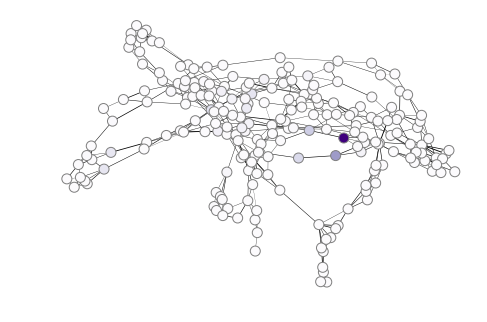

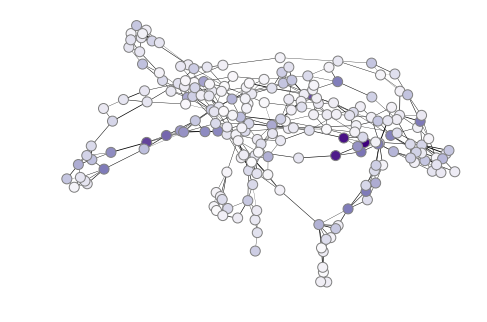

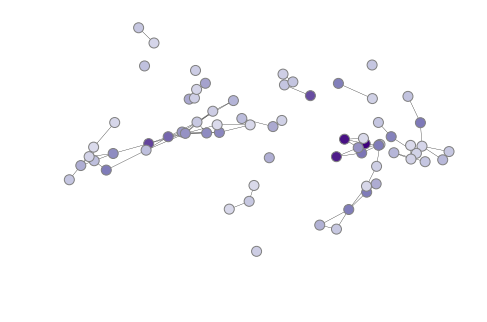

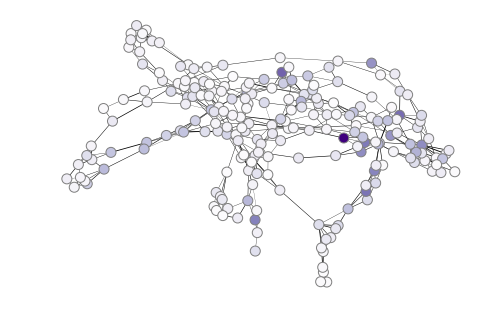

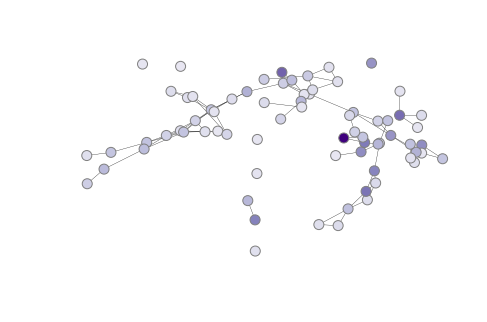

In [139]:
save = True
for index in [640]:#range(len(data_test.adj_list)):
    A = data_test.adj_list[index]
    n = A.shape[0]    
    idx_d = np.where(alpha_wsup[index] <= thresh)[0]
    label = data_test.labels[index]    
    r = len(idx_d) / float(n) * 100
    if r < 30 or n > 230:
        continue
    pred = pred_wsup[index]
    if label == pred:
        sfx = 'pos'
#         graph_pos.append((A, alpha_wsup[index], label))
    else:
        sfx = 'neg'
#         graph_neg.append((A, alpha_wsup[index], label))
    if label != pred:# or pred != 1:
        continue
    A, G, pos = get_graph(data_test, index, draw=False)
    print(index, sfx, label, pred, r)
    
    fig = plt.figure()
    nx.draw(G, pos, node_size=100, node_color=attn_WS[index], #graph_pos[0][1], 
            edgecolors=edgecolors, width=A.sum(1) / 10., cmap=cmap)    
    if save:
        plt.savefig('images/dd/wsup/label%d/%s/%d_%d_%dnodes_%d_%d_global.pdf' % 
                (label, sfx, r, index, n, label, pred_global[index]))
    plt.show()
    

    
    fig = plt.figure()
    nx.draw(G, pos, node_size=100, node_color=alpha_unsup[index], #graph_pos[0][1], 
            edgecolors=edgecolors, width=A.sum(1) / 10., cmap=cmap)    
    if save:
        plt.savefig('images/dd/wsup/label%d/%s/%d_%d_%dnodes_%d_%d_unsup.pdf' % 
                (label, sfx, r, index, n, label, pred_unsup[index]))
    plt.show()
    
    n = plot_pooled(index, alpha_unsup, thresh_unsup)
    plt.axis('off')
    plt.savefig('images/dd/wsup/label%d/%s/%d_%d_%dnodes_%d_%d_unsup_pooled.pdf' % (label, sfx, r, 
                                                                                    index, n, label, pred_unsup[index]))
    
        
    fig = plt.figure()
    nx.draw(G, pos, node_size=100, node_color=alpha_wsup[index], #graph_pos[0][1], 
            edgecolors=edgecolors, width=A.sum(1) / 10., cmap=cmap)    
    if save:
        plt.savefig('images/dd/wsup/label%d/%s/%d_%d_%dnodes_%d_%d.pdf' % (label, sfx, r, 
                                                                             index, A.shape[0], label, pred))
    plt.show()
    
    n = plot_pooled(index, alpha_wsup, thresh)
    plt.axis('off')
    if save:
        plt.savefig('images/dd/wsup/label%d/%s/%d_%d_%dnodes_%d_%d_pooled.pdf' % (label, sfx, r, 
                                                                                    index, n, label, pred_wsup[index]))
#     plt.savefig('images/proteins/wsup/label%d/%s/%d_pooled_%dnodes.png' % (label, sfx, index, n), 
#                 dpi=300, transparent=True)
    plt.show()
# len(graph_pos), len(graph_neg)

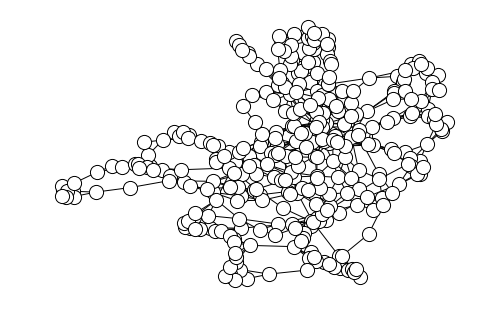

label 0


In [61]:
index = 0
A, G, pos = get_graph(data_test, index)

In [158]:
n = A.shape[0]
data = (torch.from_numpy(data_test.features_onehot[index]).unsqueeze(0).float().to(device).expand(2, -1, -1),
            None,
            torch.from_numpy(A).unsqueeze(0).unsqueeze(3).float().to(device).to(device).expand(2, -1, -1, -1),
            {'graph_support': torch.ones(2, n).float().to(device).to(device),
             'N_nodes': torch.zeros(2, 1).long().to(device) + n,
             'signal_attn': torch.zeros(2, n).float().to(device)})
y, output = model(data)[:2]
print(y, output[1][0].shape)
alpha = output[1][0][0, :].data.numpy()

tensor([[-0.1876,  0.3212],
        [-0.1876,  0.3212]], grad_fn=<ThAddmmBackward>) torch.Size([2, 182])


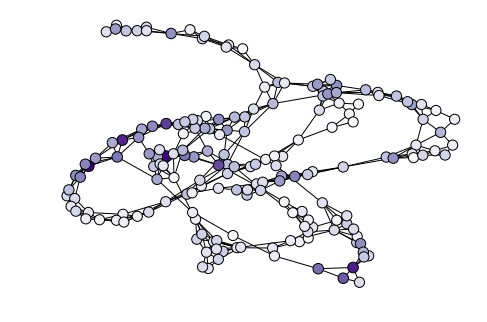

In [159]:
nx.draw(G, pos, node_color=alpha, node_size=(alpha + 0.1) * 1000, edgecolors=np.zeros(3), cmap='Purples')
plt.show()

## Show correctly and incorrectly classified samples